# Machine Learning predictive Model

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# ---- Load Dataset ----
df = pd.read_csv(r"C:\Users\User\Downloads\archive (2)\telecom_churn_data.csv")  # Update with your actual dataset path

# Assuming 'phone_number' is the unique customer identifier
df['customer_id'] = df['mobile_number']

# ---- Feature Engineering ----
columns_to_keep = [
    'total_og_mou_6', 'total_og_mou_7',
    'total_ic_mou_6', 'total_ic_mou_7',
    'onnet_mou_6', 'onnet_mou_7',
    'offnet_mou_6', 'offnet_mou_7',
    'vol_2g_mb_6', 'vol_2g_mb_7',
    'vol_3g_mb_6', 'vol_3g_mb_7',
    'arpu_7','arpu_6', 'aon'
]

df_train = df[columns_to_keep].copy()

# Add the active indicator
df_train['active_indicator'] = df_train[
    ['total_og_mou_6', 'total_og_mou_7', 'total_ic_mou_6', 'total_ic_mou_7',
     'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7',
     'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_6', 'vol_3g_mb_7']
].sum(axis=1) > 0

# Calculate CLV score
df_train['clv_score'] = (df_train['arpu_6'] * df_train['aon']/365)

# Define service type mapping function
def map_service_type(row, vol_2g_col, vol_3g_col):
    if row[vol_3g_col] > 0 and row[vol_2g_col] == 0:
        return '3G'
    elif row[vol_2g_col] > 0 and row[vol_3g_col] == 0:
        return '2G'
    elif row[vol_3g_col] > 0 and row[vol_2g_col] > 0:
        return 'Mixed'
    else:
        return 'No Service'

# Apply service type mapping
df_train['service_type_6'] = df_train.apply(
    lambda row: map_service_type(row, vol_2g_col='vol_2g_mb_6', vol_3g_col='vol_3g_mb_6'), axis=1
)
df_train['service_type_7'] = df_train.apply(
    lambda row: map_service_type(row, vol_2g_col='vol_2g_mb_7', vol_3g_col='vol_3g_mb_7'), axis=1
)

# Map service types to numerical values
service_type_mapping = {'3G': 1, '2G': 2, 'Mixed': 3, 'No Service': 0}
df_train['service_type_6'] = df_train['service_type_6'].map(service_type_mapping)
df_train['service_type_7'] = df_train['service_type_7'].map(service_type_mapping)

# Handle missing values
df_train = df_train.fillna(0)

# ---- Feature Selection ----
feature_columns = [
    'total_og_mou_6', 'total_og_mou_7',
    'total_ic_mou_6', 'total_ic_mou_7',
    'onnet_mou_6', 'onnet_mou_7',
    'offnet_mou_6', 'offnet_mou_7',
    'vol_2g_mb_6', 'vol_2g_mb_7',
    'vol_3g_mb_6', 'vol_3g_mb_7',
    'arpu_7','arpu_6','aon'
]

# ---- Model Training ----

# Active Indicator Model
X_active_train, X_active_val, y_active_train, y_active_val = train_test_split(
    df_train[feature_columns], df_train['active_indicator'], test_size=0.2, random_state=42
)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_active_train, y_active_train)
active_val_pred = rf_classifier.predict(X_active_val)
active_val_accuracy = accuracy_score(y_active_val, active_val_pred)

# ARPU Prediction Model
X_arpu_train, X_arpu_val, y_arpu_train, y_arpu_val = train_test_split(
    df_train[feature_columns], df_train['arpu_7'], test_size=0.2, random_state=42
)
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_arpu_train, y_arpu_train)
arpu_val_pred = rf_regressor.predict(X_arpu_val)
arpu_mse = mean_squared_error(y_arpu_val, arpu_val_pred)
arpu_r2 = r2_score(y_arpu_val, arpu_val_pred)

# CLV Prediction Model
X_clv_train, X_clv_val, y_clv_train, y_clv_val = train_test_split(
    df_train[feature_columns], df_train['clv_score'], test_size=0.2, random_state=42
)
rf_clv_regressor = RandomForestRegressor(random_state=42)
rf_clv_regressor.fit(X_clv_train, y_clv_train)
clv_val_pred = rf_clv_regressor.predict(X_clv_val)
clv_mse = mean_squared_error(y_clv_val, clv_val_pred)
clv_r2 = r2_score(y_clv_val, clv_val_pred)

# Service Usage Prediction Model
X_service_train, X_service_val, y_service_train, y_service_val = train_test_split(
    df_train[feature_columns], df_train['service_type_7'], test_size=0.2, random_state=42
)
rf_service_classifier = RandomForestClassifier(random_state=42)
rf_service_classifier.fit(X_service_train, y_service_train)
service_val_pred = rf_service_classifier.predict(X_service_val)
service_val_accuracy = accuracy_score(y_service_val, service_val_pred)

# ---- Results ----
print(f"Active Indicator Validation Accuracy: {active_val_accuracy * 100:.2f}%")
print(f"ARPU Prediction - MSE: {arpu_mse:.2f}, R2 Score: {arpu_r2:.2f}")
print(f"CLV Prediction - MSE: {clv_mse:.2f}, R2 Score: {clv_r2:.2f}")
print(f"Service Usage Mapping Validation Accuracy: {service_val_accuracy * 100:.2f}%")


Active Indicator Validation Accuracy: 99.98%
ARPU Prediction - MSE: 1974.36, R2 Score: 0.98
CLV Prediction - MSE: 14216.79, R2 Score: 0.99
Service Usage Mapping Validation Accuracy: 100.00%


## using ML model to predict for the 8 th month pridiction using 6 and 7 th month data and making in data frame 

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ---- Load Data ----
# Load the dataset
df = pd.read_csv(r"C:\Users\User\Downloads\archive (2)\telecom_churn_data.csv")  # Update the path accordingly

# Ensure required columns for Month 6 and Month 7 are present
columns_to_keep = [
    'total_og_mou_6', 'total_og_mou_7',
    'total_ic_mou_6', 'total_ic_mou_7',
    'onnet_mou_6', 'onnet_mou_7',
    'offnet_mou_6', 'offnet_mou_7',
    'vol_2g_mb_6', 'vol_2g_mb_7',
    'vol_3g_mb_6', 'vol_3g_mb_7',
    'arpu_7', 'arpu_6','aon', 'mobile_number'
]
df_train = df[columns_to_keep].copy()

# ---- Feature Engineering ----
# Active Indicator
df_train['active_indicator'] = df_train[['total_og_mou_6', 'total_og_mou_7', 'total_ic_mou_6', 'total_ic_mou_7',
                                         'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7',
                                         'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_6', 'vol_3g_mb_7']].sum(axis=1) > 0

# CLV score
df_train['clv_score'] = (df_train['arpu_7'] * df_train['aon']/365)

# Service Type Mapping
def map_service_type(row, vol_2g_col, vol_3g_col):
    if row[vol_3g_col] > 0 and row[vol_2g_col] == 0:
        return '3G'
    elif row[vol_2g_col] > 0 and row[vol_3g_col] == 0:
        return '2G'
    elif row[vol_3g_col] > 0 and row[vol_2g_col] > 0:
        return 'Mixed'
    else:
        return 'No Service'

# Apply service type mapping
df_train['service_type_6'] = df_train.apply(lambda row: map_service_type(row, 'vol_2g_mb_6', 'vol_3g_mb_6'), axis=1)
df_train['service_type_7'] = df_train.apply(lambda row: map_service_type(row, 'vol_2g_mb_7', 'vol_3g_mb_7'), axis=1)

# Map service types to numeric
service_type_mapping = {'3G': 1, '2G': 2, 'Mixed': 3, 'No Service': 0}
df_train['service_type_6'] = df_train['service_type_6'].map(service_type_mapping)
df_train['service_type_7'] = df_train['service_type_7'].map(service_type_mapping)

# Define features and target columns
feature_columns = [
    'total_og_mou_6', 'total_og_mou_7',
    'total_ic_mou_6', 'total_ic_mou_7',
    'onnet_mou_6', 'onnet_mou_7',
    'offnet_mou_6', 'offnet_mou_7',
    'vol_2g_mb_6', 'vol_2g_mb_7',
    'vol_3g_mb_6', 'vol_3g_mb_7',
    'arpu_7','arpu_6', 'aon'
]

# ---- Split Data for Training ----
X = df_train[feature_columns]
y_active = df_train['active_indicator']
y_arpu = df_train['arpu_7']
y_clv = df_train['clv_score']
y_service = df_train['service_type_6']

X_train, X_val, y_active_train, y_active_val = train_test_split(X, y_active, test_size=0.2, random_state=42)
_, _, y_arpu_train, y_arpu_val = train_test_split(X, y_arpu, test_size=0.2, random_state=42)
_, _, y_clv_train, y_clv_val = train_test_split(X, y_clv, test_size=0.2, random_state=42)
_, _, y_service_train, y_service_val = train_test_split(X, y_service, test_size=0.2, random_state=42)

# ---- Train Models ----
# Active Indicator Model
rf_active = RandomForestClassifier(random_state=42)
rf_active.fit(X_train, y_active_train)

# ARPU Model
rf_arpu = RandomForestRegressor(random_state=42)
rf_arpu.fit(X_train, y_arpu_train)

# CLV Model
rf_clv = RandomForestRegressor(random_state=42)
rf_clv.fit(X_train, y_clv_train)

# Service Type Model
rf_service = RandomForestClassifier(random_state=42)
rf_service.fit(X_train, y_service_train)

# ---- Make Predictions for Next Month ----
# For the same dataset (Months 6 and 7), predict for Month 8
df_pred = df_train.copy()  # Use the same data for prediction

X_pred = df_pred[feature_columns]

# Predict Active Indicator
df_pred['active_indicator_pred'] = rf_active.predict(X_pred)

# Predict ARPU for Month 8
df_pred['arpu_pred'] = rf_arpu.predict(X_pred)

# Predict CLV for Month 8
df_pred['clv_pred'] = rf_clv.predict(X_pred)

# Predict Service Type for Month 8
df_pred['service_type_pred'] = rf_service.predict(X_pred)

# Map service type predictions back to labels
reverse_service_type_mapping = {1: '3G', 2: '2G', 3: 'Mixed', 0: 'No Service'}
df_pred['service_type_pred_label'] = df_pred['service_type_pred'].map(reverse_service_type_mapping)

# ---- Save or Display Predictions ----
prediction_columns = ['mobile_number', 'active_indicator_pred', 'arpu_pred', 'clv_pred', 'service_type_pred_label']
df_predictions = df_pred[prediction_columns]

# Save predictions to a CSV file
df_predictions.to_csv('month_8_predictions.csv', index=False)

# Display predictions
print(df_predictions.head())


   mobile_number  active_indicator_pred  arpu_pred     clv_pred  \
0     7000842753                   True  214.81840   571.319087   
1     7001865778                   True  355.07233   978.322620   
2     7001625959                   True  189.05592   570.929688   
3     7001204172                   True  251.10263  1712.989979   
4     7000142493                   True  309.87716  1296.872936   

  service_type_pred_label  
0                   Mixed  
1              No Service  
2              No Service  
3              No Service  
4              No Service  


In [4]:
df_predictions

,mobile_number,active_indicator_pred,arpu_pred,clv_pred,service_type_pred_label
0,7000842753,True,214.81840,571.319087,Mixed
1,7001865778,True,355.07233,978.322620,No Service
2,7001625959,True,189.05592,570.929688,No Service
3,7001204172,True,251.10263,1712.989979,No Service
4,7000142493,True,309.87716,1296.872936,No Service
...,...,...,...,...,...
99994,7001548952,True,69.16042,609.328878,No Service
99995,7000607688,True,77.81024,438.037879,No Service
99996,7000087541,True,0.00000,0.000000,Mixed
99997,7000498689,True,303.38685,398.227410,Mixed


## importing real 8th month data 

In [5]:
import pandas as pd

# Load the original August data
aug_data = pd.read_csv(r"D:\projects\filtered_test_data_aug.csv")

# Ensure required columns are present
required_columns = [
    'total_og_mou_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_8', 'aon'
]

for col in required_columns:
    if col not in aug_data.columns:
        raise ValueError(f"Missing required column: {col}")

# ---- Calculate Service Usage Mapping ---
# Service Type Mapping
def map_service_type(row, vol_2g_col, vol_3g_col):
    if row[vol_3g_col] > 0 and row[vol_2g_col] == 0:
        return '3G'
    elif row[vol_2g_col] > 0 and row[vol_3g_col] == 0:
        return '2G'
    elif row[vol_3g_col] > 0 and row[vol_2g_col] > 0:
        return 'Mixed'
    else:
        return 'No Service'

# Apply service type mapping
aug_data['service_type_8'] = aug_data.apply(lambda row: map_service_type(row, 'vol_2g_mb_8', 'vol_3g_mb_8'), axis=1)

# Map service types to numeric
service_type_mapping = {'3G': 1, '2G': 2, 'Mixed': 3, 'No Service': 0}
aug_data['service_type_8'] = aug_data['service_type_8'].map(service_type_mapping)

# Map numeric values back to string aliases
reverse_service_type_mapping = {v: k for k, v in service_type_mapping.items()}
aug_data['service_type_8'] = aug_data['service_type_8'].map(reverse_service_type_mapping)

# ---- Calculate CLV Score ----
aug_data['clv_score'] = (aug_data['arpu_8'] * aug_data['aon']/365)

# Display the updated dataframe
print(aug_data.head())

# Optional: Save the updated data to a new CSV file
aug_data.to_csv("aug_data_with_calculated_columns.csv", index=False)
print("Updated dataset saved to 'aug_data_with_calculated_columns.csv'")


   total_og_mou_8  total_ic_mou_8  onnet_mou_8  offnet_mou_8  vol_2g_mb_8  \
0            0.00            5.44         0.00          0.00         5.75   
1          312.44          423.28         7.68        304.76       365.47   
2          285.46          395.03        37.26        208.36         0.00   
3          352.21           53.13       310.98         71.68         0.00   
4          208.16          338.81        83.89        124.26         0.00   

   vol_3g_mb_8   aon   arpu_8 service_type_8    clv_score  
0       109.61   968  213.803          Mixed   567.017271  
1         0.00  1006  268.321             2G   739.536784  
2         0.00  1103  210.226     No Service   635.285693  
3         0.00  2491  508.054     No Service  3467.294559  
4         0.00  1526  238.174     No Service   995.763079  
Updated dataset saved to 'aug_data_with_calculated_columns.csv'


In [6]:
df_predictions

,mobile_number,active_indicator_pred,arpu_pred,clv_pred,service_type_pred_label
0,7000842753,True,214.81840,571.319087,Mixed
1,7001865778,True,355.07233,978.322620,No Service
2,7001625959,True,189.05592,570.929688,No Service
3,7001204172,True,251.10263,1712.989979,No Service
4,7000142493,True,309.87716,1296.872936,No Service
...,...,...,...,...,...
99994,7001548952,True,69.16042,609.328878,No Service
99995,7000607688,True,77.81024,438.037879,No Service
99996,7000087541,True,0.00000,0.000000,Mixed
99997,7000498689,True,303.38685,398.227410,Mixed


In [7]:
aug_data

,total_og_mou_8,total_ic_mou_8,onnet_mou_8,offnet_mou_8,vol_2g_mb_8,vol_3g_mb_8,aon,arpu_8,service_type_8,clv_score
0,0.00,5.44,0.00,0.00,5.75,109.61,968,213.803,Mixed,567.017271
1,312.44,423.28,7.68,304.76,365.47,0.00,1006,268.321,2G,739.536784
2,285.46,395.03,37.26,208.36,0.00,0.00,1103,210.226,No Service,635.285693
3,352.21,53.13,310.98,71.68,0.00,0.00,2491,508.054,No Service,3467.294559
4,208.16,338.81,83.89,124.26,0.00,0.00,1526,238.174,No Service,995.763079
...,...,...,...,...,...,...,...,...,...,...
99994,58.71,160.83,5.91,52.79,0.00,0.00,3199,57.530,No Service,504.214986
99995,82.46,67.81,16.06,66.39,0.00,0.00,2052,79.081,No Service,444.586882
99996,0.00,0.00,NaN,NaN,0.00,0.00,185,0.000,No Service,0.000000
99997,0.00,2.29,0.00,0.00,136.47,2683.30,478,606.817,Mixed,794.680893


In [8]:
# Define the columns to keep
columns = ["aon", "service_type_8", "clv_score","arpu_8"]

# Merge the mobile_number column from df into aug_data
aug_data["mobile_number"] = df["mobile_number"]

# Select the required columns including mobile_number
aug_data_1 = aug_data[["mobile_number"]+ columns]


In [9]:
df_predictions.columns

Index(['mobile_number', 'active_indicator_pred', 'arpu_pred', 'clv_pred',
       'service_type_pred_label'],
      dtype='object')

In [22]:
aug_data_1.columns

Index(['mobile_number', 'aon', 'service_type_8', 'clv_score', 'arpu_8'], dtype='object')

In [23]:
df_predictions.columns

Index(['mobile_number', 'active_indicator_pred', 'arpu_pred', 'clv_pred',
       'service_type_pred_label'],
      dtype='object')

# p

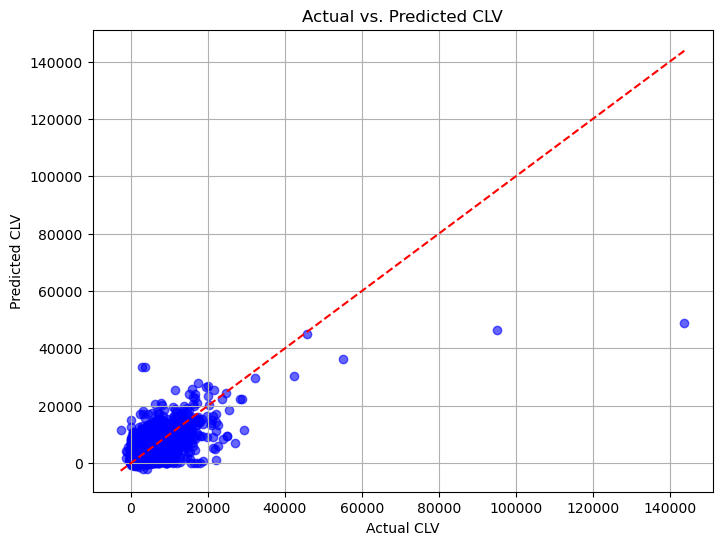

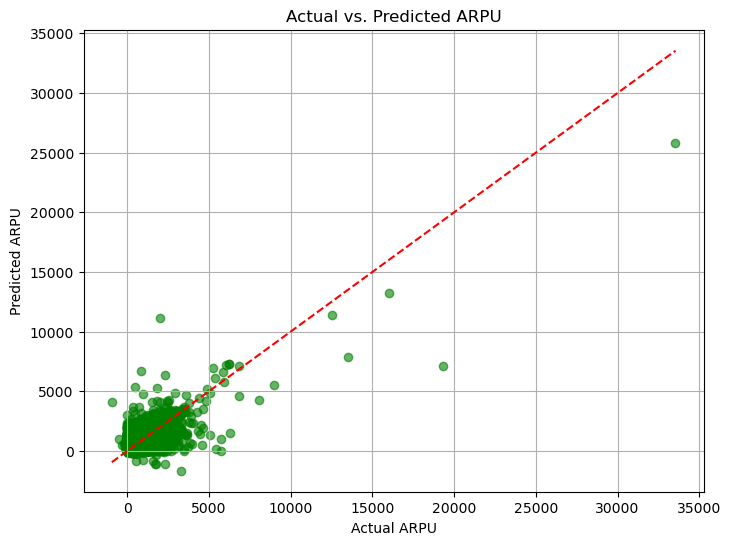

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(aug_data_1["clv_score"], df_predictions["clv_pred"], alpha=0.6, color="blue")
plt.plot([min(aug_data_1["clv_score"]), max(aug_data_1["clv_score"])],
         [min(aug_data_1["clv_score"]), max(aug_data_1["clv_score"])], color='red', linestyle='--')
plt.title("Actual vs. Predicted CLV")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(aug_data_1["arpu_8"], df_predictions["arpu_pred"], alpha=0.6, color="green")
plt.plot([min(aug_data_1["arpu_8"]), max(aug_data_1["arpu_8"])],
         [min(aug_data_1["arpu_8"]), max(aug_data_1["arpu_8"])], color='red', linestyle='--')
plt.title("Actual vs. Predicted ARPU")
plt.xlabel("Actual ARPU")
plt.ylabel("Predicted ARPU")
plt.grid(True)
plt.show()



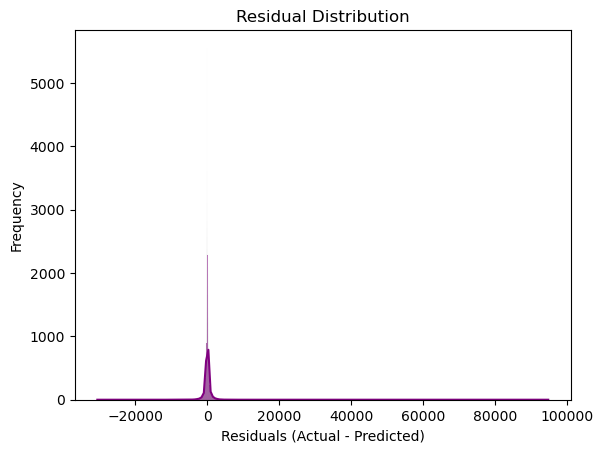

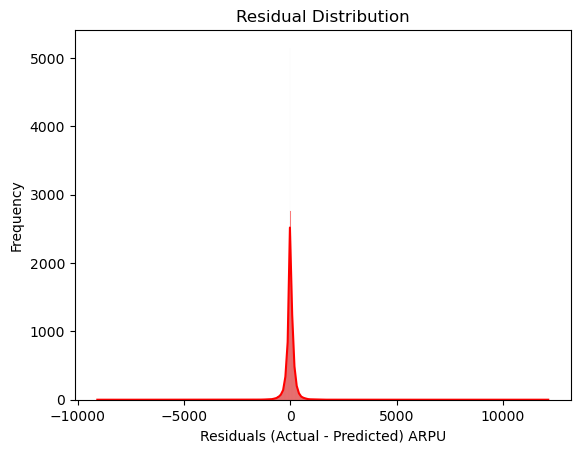

In [27]:
import seaborn as sns

residuals = aug_data_1["clv_score"] - df_predictions["clv_pred"]
sns.histplot(residuals, kde=True, color="purple")
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


residuals = aug_data_1["arpu_8"] - df_predictions["arpu_pred"]
sns.histplot(residuals, kde=True, color="red")
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted) ARPU")
plt.ylabel("Frequency")
plt.show()


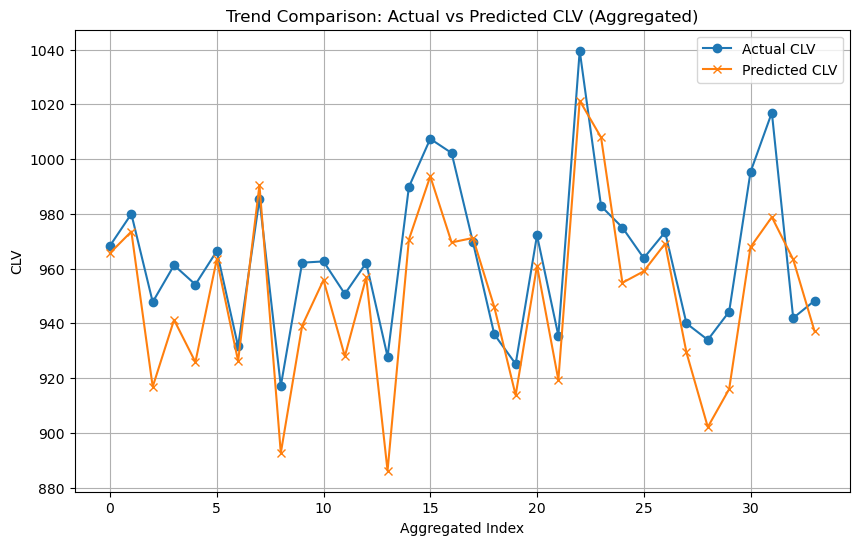

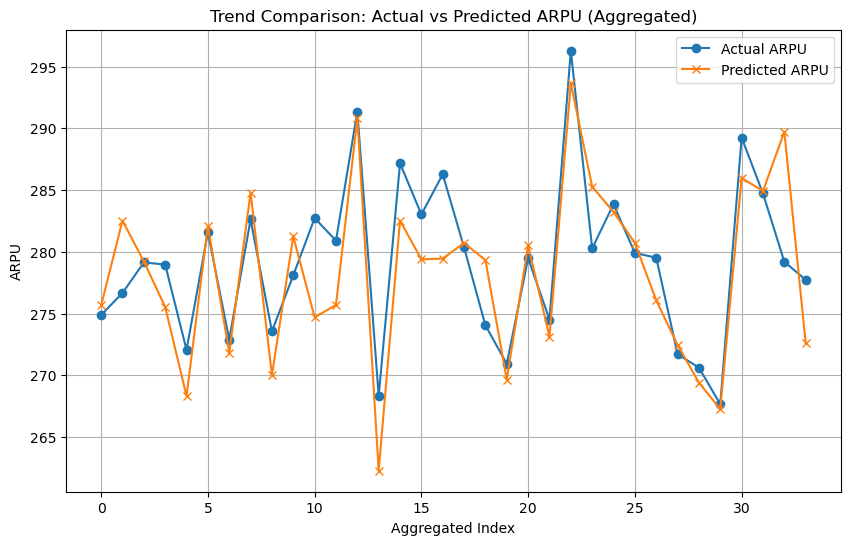

In [46]:
# Aggregating data (e.g., by every 1000 customers for clarity)
aggregated_actual = aug_data_1.groupby(aug_data_1.index // 3000)["clv_score"].mean()
aggregated_predicted = df_predictions.groupby(df_predictions.index // 3000)["clv_pred"].mean()

# Plotting aggregated data
plt.figure(figsize=(10, 6))
plt.plot(aggregated_actual.index, aggregated_actual, label="Actual CLV", marker="o")
plt.plot(aggregated_predicted.index, aggregated_predicted, label="Predicted CLV", marker="x")
plt.title("Trend Comparison: Actual vs Predicted CLV (Aggregated)")
plt.xlabel("Aggregated Index")
plt.ylabel("CLV")
plt.legend()
plt.grid(True)
plt.show()

# Aggregating data (e.g., by every 1000 customers for clarity)
aggregated_actual = aug_data_1.groupby(aug_data_1.index // 3000)["arpu_8"].mean()
aggregated_predicted = df_predictions.groupby(df_predictions.index // 3000)["arpu_pred"].mean()

# Plotting aggregated data
plt.figure(figsize=(10, 6))
plt.plot(aggregated_actual.index, aggregated_actual, label="Actual ARPU", marker="o")
plt.plot(aggregated_predicted.index, aggregated_predicted, label="Predicted ARPU", marker="x")
plt.title("Trend Comparison: Actual vs Predicted ARPU (Aggregated)")
plt.xlabel("Aggregated Index")
plt.ylabel("ARPU")
plt.legend()
plt.grid(True)
plt.show()


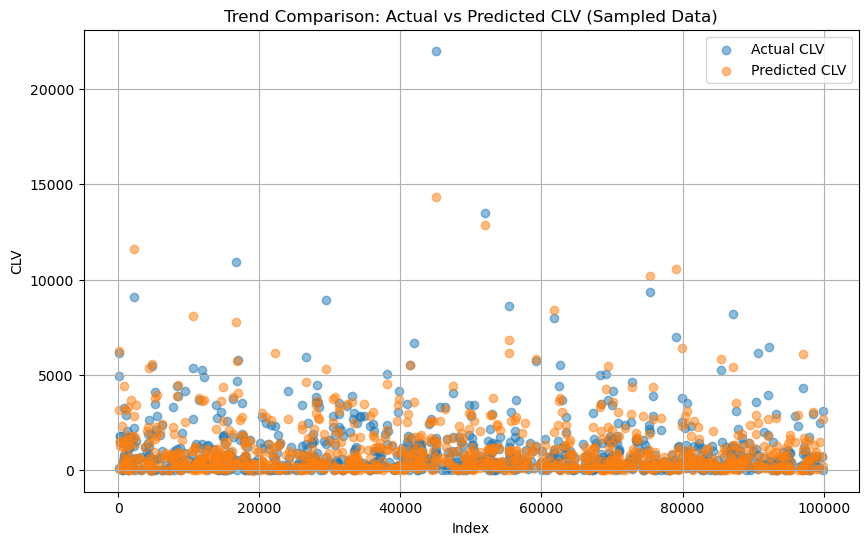

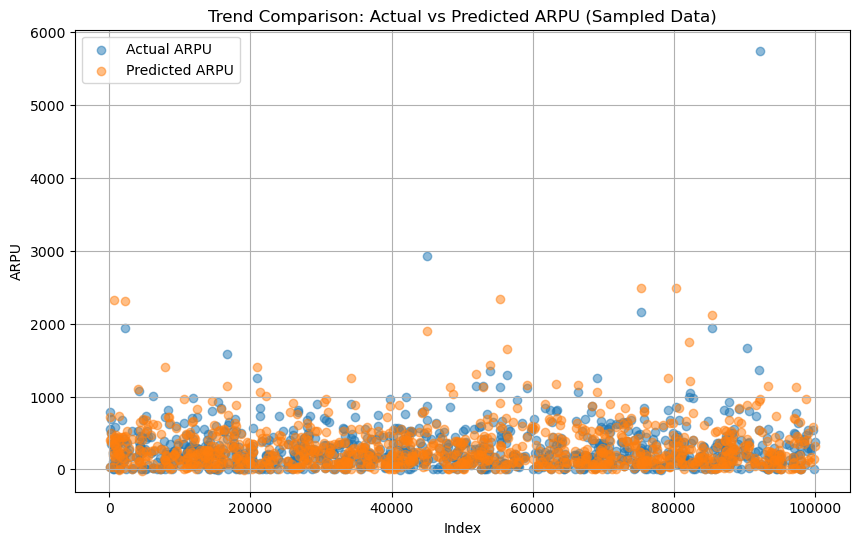

In [34]:
# Sampling data for visualization
sample_actual = aug_data_1.sample(n=1000, random_state=42)
sample_predicted = df_predictions.loc[sample_actual.index]

# Plotting sampled data
plt.figure(figsize=(10, 6))
plt.scatter(sample_actual.index, sample_actual["clv_score"], label="Actual CLV", alpha=0.5)
plt.scatter(sample_predicted.index, sample_predicted["clv_pred"], label="Predicted CLV", alpha=0.5)
plt.title("Trend Comparison: Actual vs Predicted CLV (Sampled Data)")
plt.xlabel("Index")
plt.ylabel("CLV")
plt.legend()
plt.grid(True)
plt.show()

# Sampling data for visualization
sample_actual = aug_data_1.sample(n=1000, random_state=42)
sample_predicted = df_predictions.loc[sample_actual.index]

# Plotting sampled data
plt.figure(figsize=(10, 6))
plt.scatter(sample_actual.index, sample_actual["arpu_8"], label="Actual ARPU", alpha=0.5)
plt.scatter(sample_predicted.index, sample_predicted["arpu_pred"], label="Predicted ARPU", alpha=0.5)
plt.title("Trend Comparison: Actual vs Predicted ARPU (Sampled Data)")
plt.xlabel("Index")
plt.ylabel("ARPU")
plt.legend()
plt.grid(True)
plt.show()



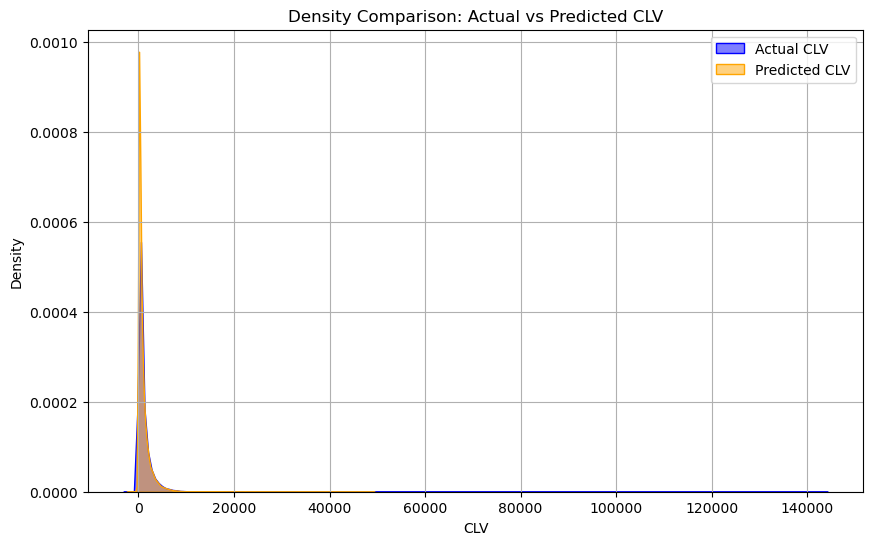

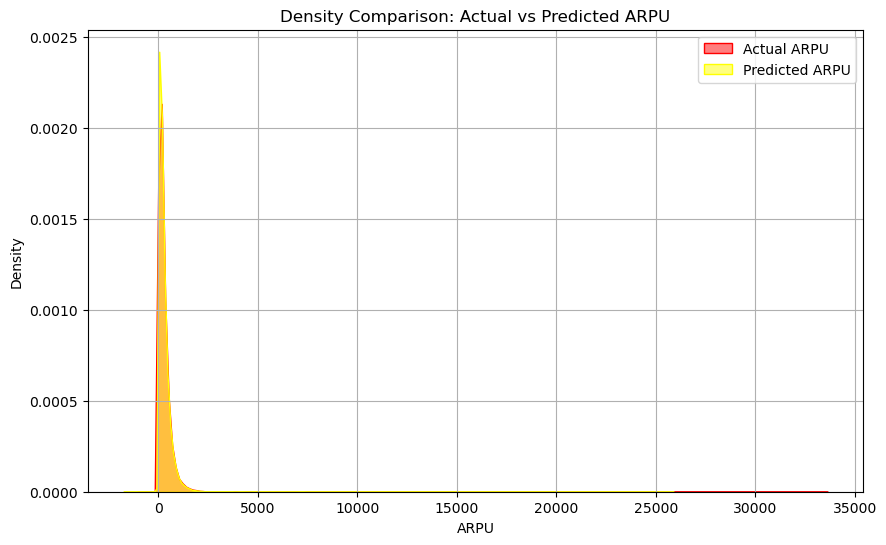

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(aug_data_1["clv_score"], label="Actual CLV", fill=True, color="blue", alpha=0.5)
sns.kdeplot(df_predictions["clv_pred"], label="Predicted CLV", fill=True, color="orange", alpha=0.5)
plt.title("Density Comparison: Actual vs Predicted CLV")
plt.xlabel("CLV")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(aug_data_1["arpu_8"], label="Actual ARPU", fill=True, color="RED", alpha=0.5)
sns.kdeplot(df_predictions["arpu_pred"], label="Predicted ARPU", fill=True, color="yellow", alpha=0.5)
plt.title("Density Comparison: Actual vs Predicted ARPU")
plt.xlabel("ARPU")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_2812\2474784042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_data_1["CLV_Rolling"] = aug_data_1["clv_score"].rolling(window=9999).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_2812\2474784042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions["CLV_Rolling"] = df_predictions["clv_pred"].rolling(window=9999).mean()


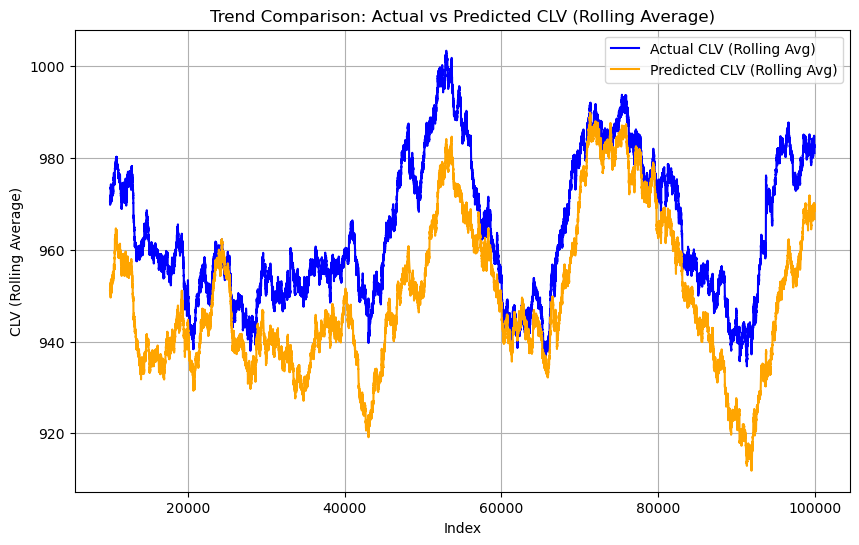

C:\Users\User\AppData\Local\Temp\ipykernel_2812\2474784042.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_data_1["CLV_Rolling"] = aug_data_1["arpu_8"].rolling(window=9999).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_2812\2474784042.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions["CLV_Rolling"] = df_predictions["arpu_pred"].rolling(window=9999).mean()


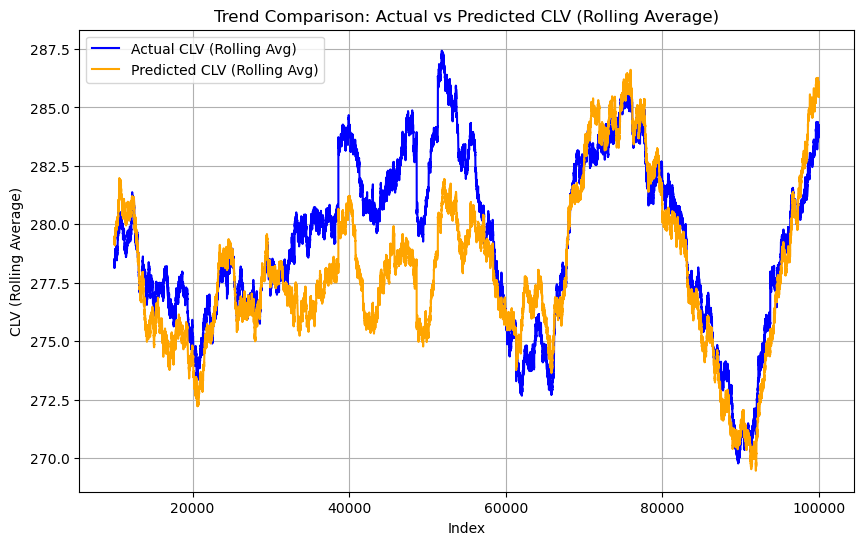

In [32]:
# Adding a rolling average column
aug_data_1["CLV_Rolling"] = aug_data_1["clv_score"].rolling(window=9999).mean()
df_predictions["CLV_Rolling"] = df_predictions["clv_pred"].rolling(window=9999).mean()

# Plotting rolling averages
plt.figure(figsize=(10, 6))
plt.plot(aug_data_1.index, aug_data_1["CLV_Rolling"], label="Actual CLV (Rolling Avg)", color="blue")
plt.plot(df_predictions.index, df_predictions["CLV_Rolling"], label="Predicted CLV (Rolling Avg)", color="orange")
plt.title("Trend Comparison: Actual vs Predicted CLV (Rolling Average)")
plt.xlabel("Index")
plt.ylabel("CLV (Rolling Average)")
plt.legend()
plt.grid(True)
plt.show()

# Adding a rolling average column
aug_data_1["CLV_Rolling"] = aug_data_1["arpu_8"].rolling(window=9999).mean()
df_predictions["CLV_Rolling"] = df_predictions["arpu_pred"].rolling(window=9999).mean()

# Plotting rolling averages
plt.figure(figsize=(10, 6))
plt.plot(aug_data_1.index, aug_data_1["CLV_Rolling"], label="Actual CLV (Rolling Avg)", color="blue")
plt.plot(df_predictions.index, df_predictions["CLV_Rolling"], label="Predicted CLV (Rolling Avg)", color="orange")
plt.title("Trend Comparison: Actual vs Predicted CLV (Rolling Average)")
plt.xlabel("Index")
plt.ylabel("CLV (Rolling Average)")
plt.legend()
plt.grid(True)
plt.show()
